In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import datasets
import scipy as sy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
class Gaussian:
    def __init__(self, mean, covar, prior, data_cluster):
        self.mean = mean
        self.covar = covar
        self.prior = prior
        self.data_cluster = data_cluster

In [56]:
class GMM:
    def __init__(self, k, data):
        # n x m 
        self.data = data
        #1 x k array 
        self.gaussians = self.make_gaussians(self.data, k)
        #will be nxm numpy array 
        self.responsibility = np.full((data.shape[0],k), 1/k)
       
 
    #mean: column vector of [[]] (m x 1)
    #covar: matrix of mxm
    def make_gaussians(self, clusters, k):
        #print("Data dim are", self.data.shape)
        gmm = []
        np.random.shuffle(self.data)
        clusters = np.array_split(self.data, k)
        for cluster in clusters:
            #print("this is cluster", cluster)
            #want mena to be a (1 x m) vector -- collapse the rows [] into one row vector -> [[]]
            m = np.mean(cluster, axis = 0, keepdims= True).T
            #print("Initial m dimensions are:", m.shape)
            #print("Initial m dtype", type(m))
            #print("Initital m is", DataFrame(m))
            covar = np.cov(cluster.T)
            #print("Initial c dimensions are:", covar.shape)
            #print("covar is", DataFrame(covar))
            #c_mv = sy.multivariate_normal(mean=m, cov=covar, allow_singular=True)
            #this is the prior value for each gaussian, of the current cluster size/total number of datapoints (n)
            prior =  np.shape(cluster)[0]/np.shape(self.data)[0]
            cluster_gaussian = Gaussian(m, covar, prior, cluster)
            gmm.append(cluster_gaussian)
        return gmm
      

    def E_step(self):
        #for every datapoint, calculate the probability that the datapoint is drawn from each distibition
        #update the responsibility matrix
        for i in range(self.data.shape[0]):
            sample =  self.data[i]
            for j in range(len(self.gaussians)):
                cluster = self.gaussians[j]
                self.responsibility[i][j] = sy.stats.multivariate_normal.pdf(x= sample, mean = cluster.mean.flatten(order ='C'), cov= cluster.covar, allow_singular=True) * cluster.prior
        #axis = 1: meaning we are iterating over columns for each row (all the k values)-> will be a n x 1 vecotore: [[], [], [], ..]
        #denominator of bayseian eq.
        self.responsibility /= self.responsibility.sum(axis=1, keepdims=True)
        #print("This is the responsibility matrix", self.responsibility)
        
        #update the prior for each gaussian/cluster
        for j in range(len(self.gaussians)):
            self.gaussians[j].prior = np.sum(self.responsibility[:,j], axis = 0)
           

    #update the model parameters: mean and covariance, prior = rk/ N
    def M_step(self):
        for j in range(len(self.gaussians)):
            cur_gaussian = self.gaussians[j]
            #get the inner product of each rij row times data matic -> 1x m vector for each mean. divide by total.n
            # [[]]: this is the form of the mean: m x 1
            cur_gaussian.mean = np.sum(self.responsibility[:,[j]] * self.data, axis = 0, keepdims=True) / (cur_gaussian.prior)
            print(cur_gaussian.mean)
            print(cur_gaussian.mean.shape)
            # m x m: 
            #cur_gaussian.covar = sum(wik*(x - u)*(x - u)^t)/ 
            cur_gaussian.covar = self.covar_calc(cur_gaussian, j)
            #normalize prior by total N
            cur_gaussian.prior = cur_gaussian.prior/self.data.shape[0]
            print("this is the prior(as unormalized rk value)for {}: {} ". format(j, self.gaussians[j].prior))
            print("this is the covar for {}: {} ".format(j, cur_gaussian.covar))
            
    def covar_calc(self, cur_gaussian, k):
        #all the k values
        covar_shape = (self.data.shape[1], self.data.shape[1])
        cur_covar = np.zeros(covar_shape)
        for i in range(self.data.shape[0]):
            sample = self.data[i].T
            r_weight = self.responsibility[i][k]
            cur_covar += r_weight * (sample - cur_gaussian.mean.T) * (sample - cur_gaussian.mean).T
        
        cur_covar /= self.responsibility[:,k].sum(axis= 0, keepdims=True)
        return cur_covar



    def fit(self, max_iter, converge = True):
        cur_step = 0
        converge_error = 1e-32
        mle_val = np.sum(np.log(np.sum(self.responsibility, axis = 1)))
        converge_arr =[]
        converge_arr.append(mle_val)
        while cur_step < max_iter:
            '''if (cur_step % 10) == 0:
                print("STEP: {}---------------------------------------".format(cur_step))
                print("Priors are", [gaus.prior for gaus in self.gaussians])
                for gaus in range(len(self.gaussians)):
                    print("The mean for Guassian {} is: ".format(gaus))
                    print(DataFrame(self.gaussians[gaus].mean))'''
            cur_step += 1
            self.E_step()
            self.M_step()
            if (converge):
                mle_val_new = np.sum(np.log(np.sum(self.responsibility, axis = 1)))
                converge_arr.append(mle_val_new)
                #print("Testing converge error current {} versus new {}".format(mle_val, mle_val_new))
                
                if np.abs(mle_val_new - mle_val) <= converge_error:
                    ''' print("GMM Model convereged in {}".format(cur_step))
                    print("Priors are", [gaus.prior for gaus in self.gaussians])
                    for gaus in range(len(self.gaussians)):
                        print("The mean for Guassian {} is: ".format(gaus))
                        print(DataFrame(self.gaussians[gaus].mean.T))'''
                    x = np.arange(0,len(converge_arr))
                    y = np.array(converge_arr)
                    plt.title("Converge error")
                    plt.xlabel("Step")
                    plt.ylabel("Error Margin")
                    plt.plot(x,y, color ="green")
                    plt.show()
                    return
                else:
                    mle_val = mle_val_new
        x = np.arange(0,len(converge_arr))
        y = np.array(converge_arr)
        plt.title("Converge error")
        plt.xlabel("Step")
        plt.ylabel("Error Margin")
        plt.plot(x,y, color ="green")
        plt.show()
        return

    def predict(self, sample, hard):
        #print("sample is \n", sample)
        probs = [gaussian.prior * sy.stats.multivariate_normal.pdf(x= self.data[sample], mean= gaussian.mean.flatten(order ='C'), cov= gaussian.covar, allow_singular=True) for gaussian in self.gaussians]
        if hard:
            #the index and the probability value
            return [np.argmax(self.responsibility[sample]), probs[np.argmax(probs)]]
            return [np.argmax(probs), probs[np.argmax(probs)]]
        else:
            return probs



# Running the Model

In [62]:
import matplotlib.pyplot as plt
wds = datasets.load_wine()
iris = datasets.load_iris()
data2 = iris.data
data = wds.data

def classify(model):
    predictions = []
    for datapoint in range(len(model.data)):  
        predictions.append(model.predict(datapoint, hard = True))
    return predictions

#c =4: 0, 1,2,3
def visualize_Data(predictions, data, c):
    np_predictions =np.array(predictions)
    #print("predicitons are", predictions)
    label = [i[0] for i in predictions]
    unique_labels = np.unique(np_predictions[:,0])
    #print("unique labels are", unique_labels)
    #print(" the PCA value  is ", c)
    #for i in range(len(unique_labels)):
    #fig = plt.figure()
    #ax1 = fig.add_subplot(111)
   
    for j in range(c-1):
        print("Showing Data for {} Gaussians and {} Components".format(len(unique_labels), c))
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        for i in unique_labels:
            ax1.scatter(data[label == i, j], data[label == i, j + 1], label = i)
        ax1.set_title('PCA{} vs PCA{}'.format(j, j+1))
        plt.show()
       

def pred_and_graph(data, k_value_list, pca_values):
    gmm_list = []
    for k in k_value_list:
        for c in pca_values:
            pca = PCA(c)
            pca.fit(data)
            temp_data = pca.transform(data)
            gmm_list.append([GMM(k, temp_data), c]) 

    for model in gmm_list:
        model[0].fit(50, True)
        predictions = classify(model[0])
        visualize_Data(predictions, model[0].data, model[1])
    return gmm_list

[[62.52930821 -3.45274482]]
(1, 2)
this is the prior(as unormalized rk value)for 0: 0.21101687387059453 
this is the covar for 0: [[1.28294474e+05 2.51469272e+02]
 [2.51469272e+02 7.26398739e+01]] 
[[70.80135944  5.30955966]]
(1, 2)
this is the prior(as unormalized rk value)for 1: 0.19819498430845048 
this is the covar for 1: [[107366.06937801   -688.55312461]
 [  -688.55312461    358.91848943]] 
[[-69.55854344  -1.41825322]]
(1, 2)
this is the prior(as unormalized rk value)for 2: 0.20514052113124592 
this is the covar for 2: [[64417.95420226   423.71247071]
 [  423.71247071   104.47663631]] 
[[-30.79024078  -1.96240275]]
(1, 2)
this is the prior(as unormalized rk value)for 3: 0.19461588870148167 
this is the covar for 3: [[94038.37931987  -462.51482743]
 [ -462.51482743   113.94628962]] 
[[-36.4634057    1.82752509]]
(1, 2)
this is the prior(as unormalized rk value)for 4: 0.19103173198822734 
this is the covar for 4: [[81279.91875713   200.38921741]
 [  200.38921741   165.3682995 ]] 


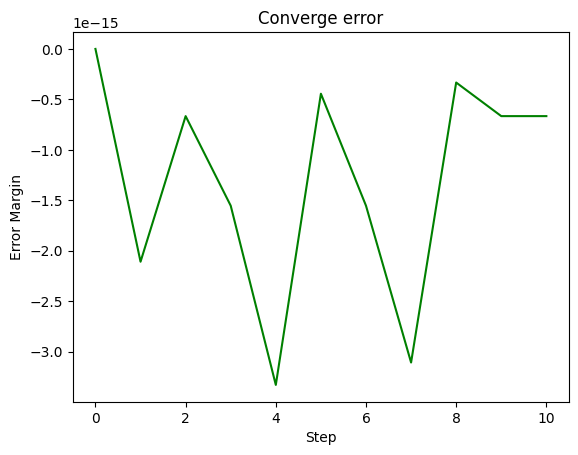

Showing Data for 5 Gaussians and 2 Components


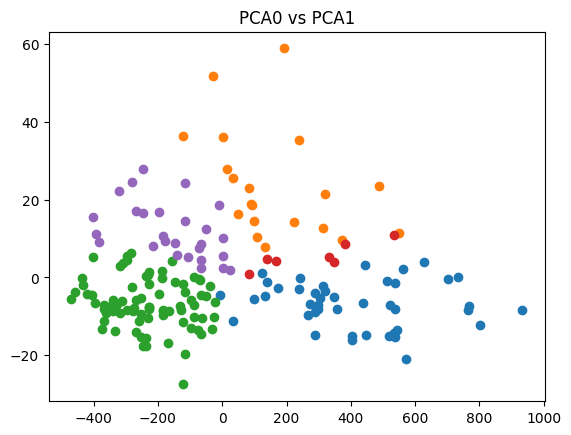

[[<__main__.GMM at 0x7f9db81d2fd0>, 2]]

In [63]:
pred_and_graph(data, [5], [2])

#  Q7: Chaning the Principle Components/ Clusters for Wine Data Set

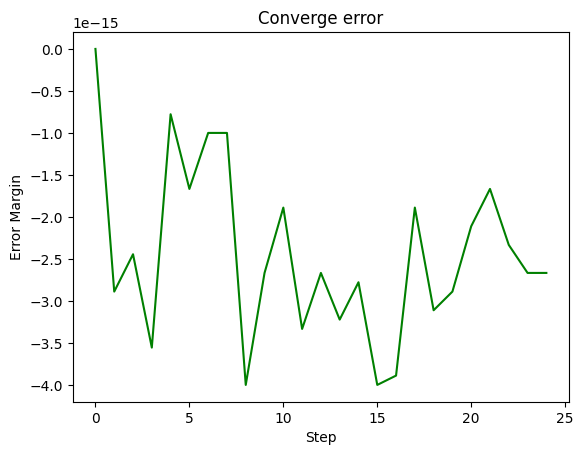

Showing Data for 3 Gaussians and 2 Components


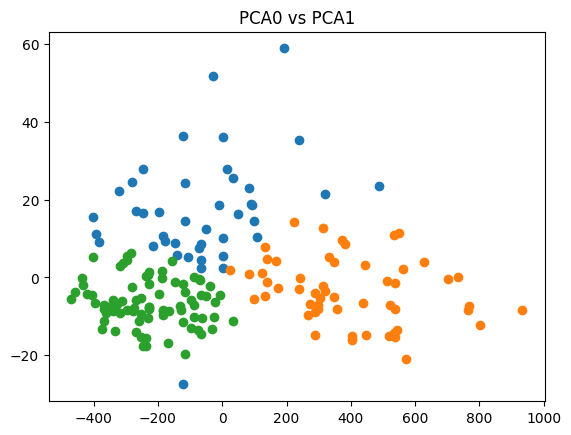

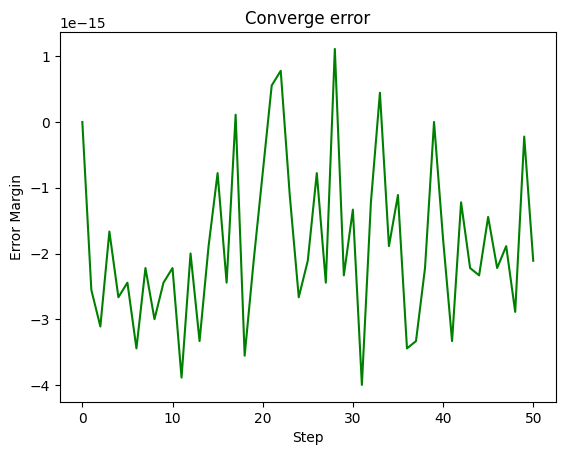

Showing Data for 3 Gaussians and 3 Components


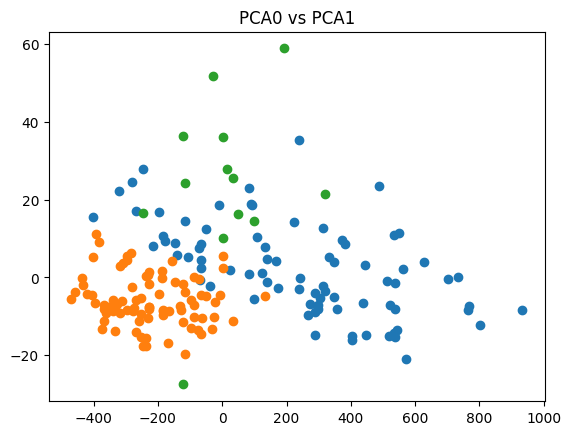

Showing Data for 3 Gaussians and 3 Components


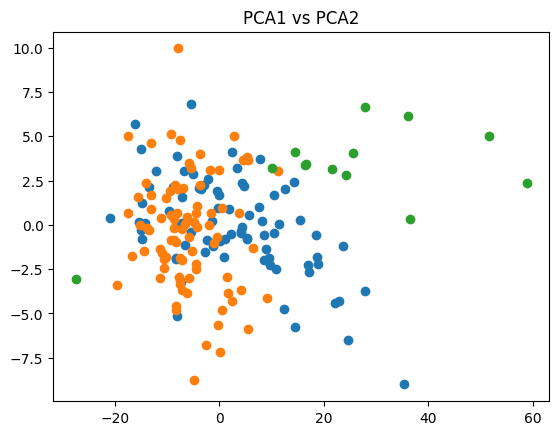

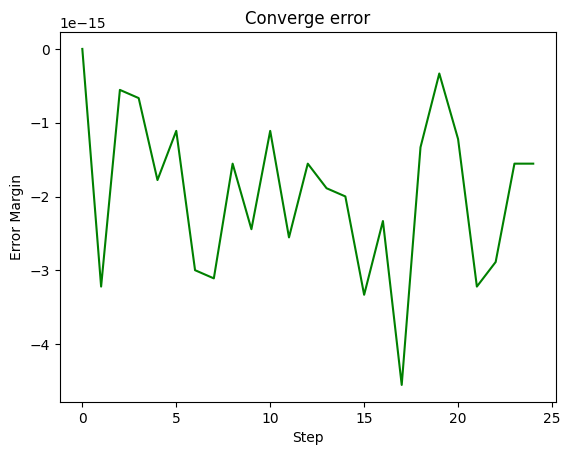

Showing Data for 5 Gaussians and 2 Components


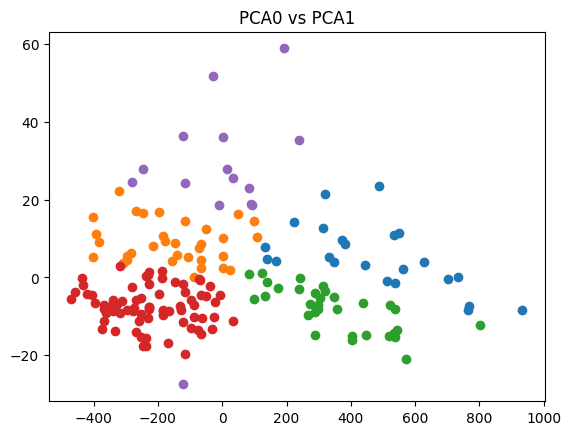

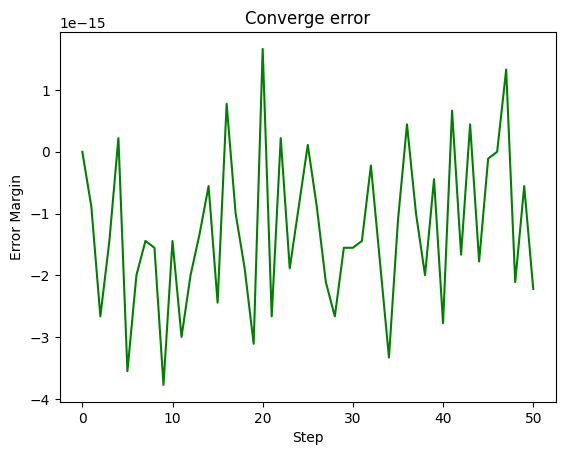

Showing Data for 5 Gaussians and 3 Components


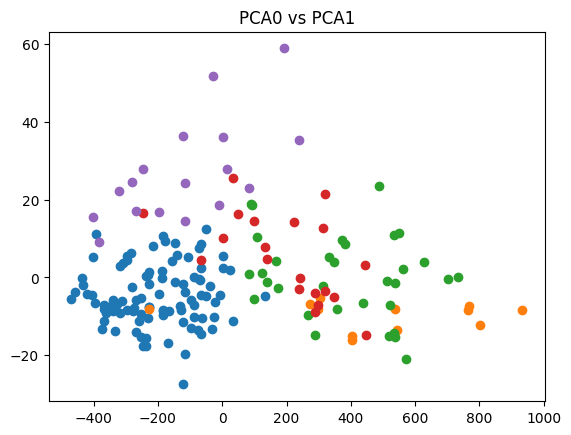

Showing Data for 5 Gaussians and 3 Components


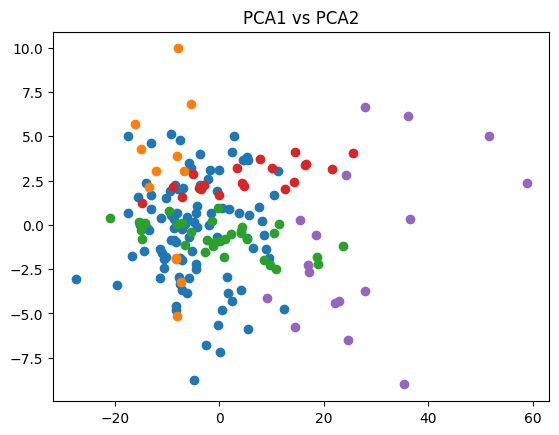

In [142]:
pred_and_graph(data, [3, 5], [2, 3])

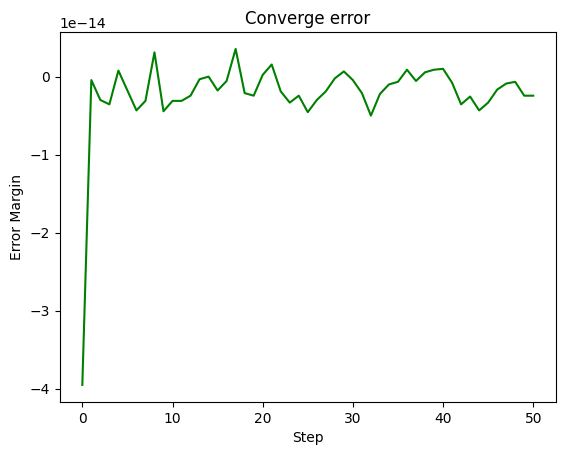

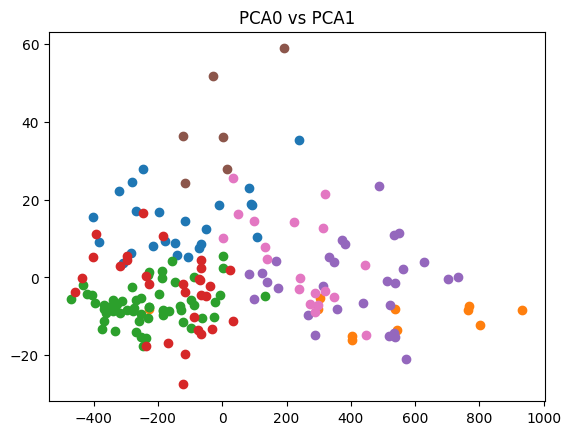

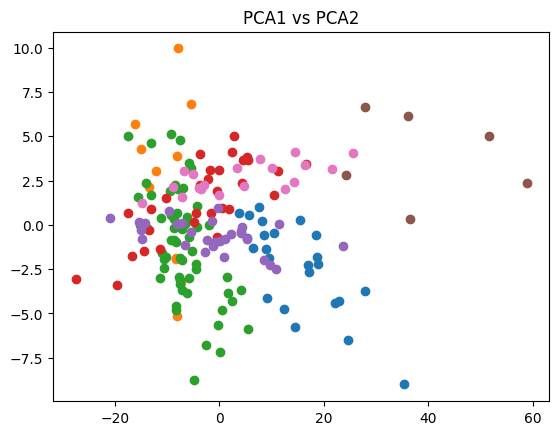

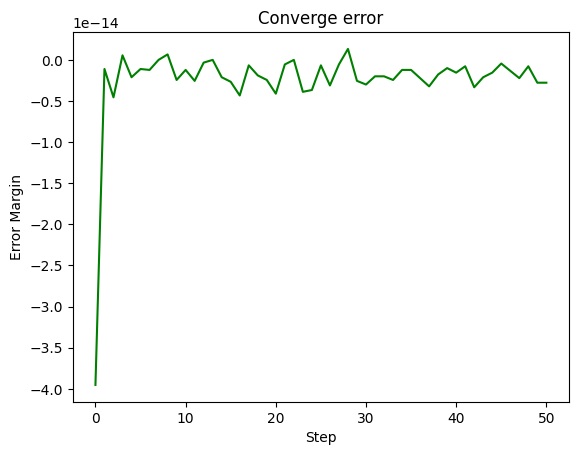

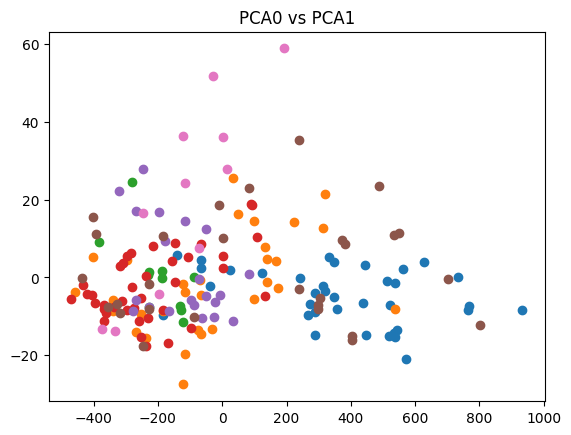

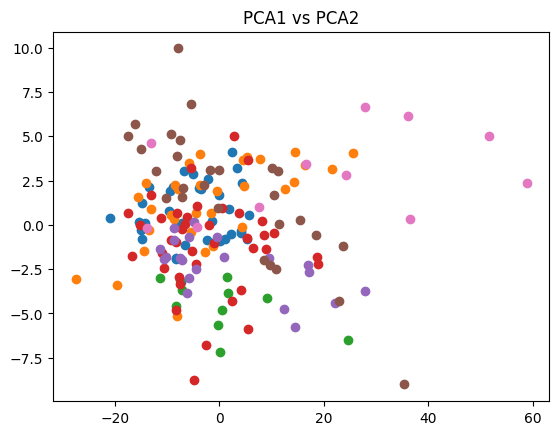

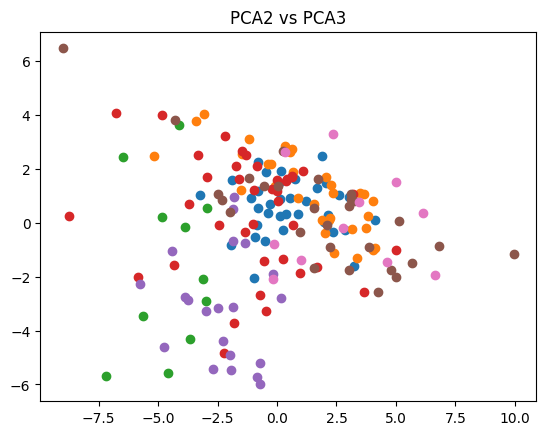

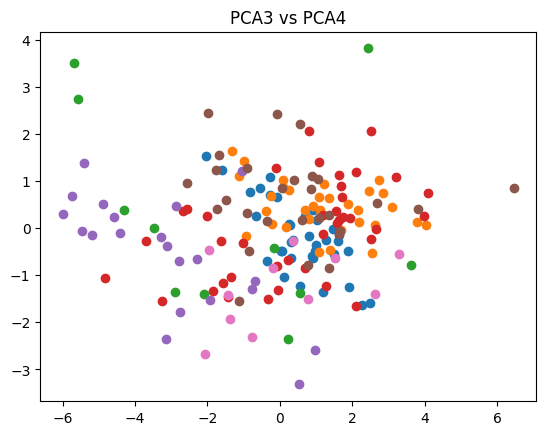

In [140]:
pred_and_graph(data, [7],  [3, 5])

# Q8: Iris Data Set

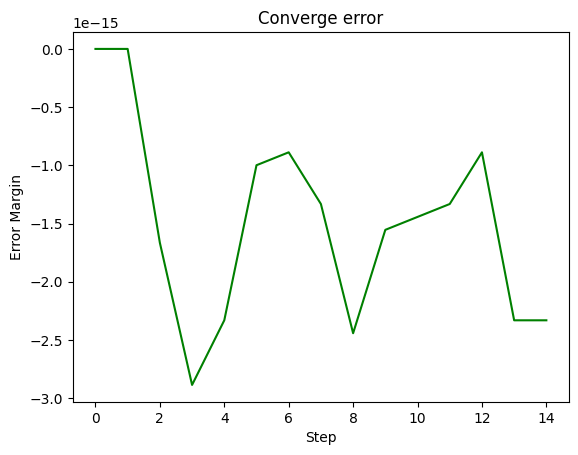

Showing Data for 2 Gaussians and 2 Components


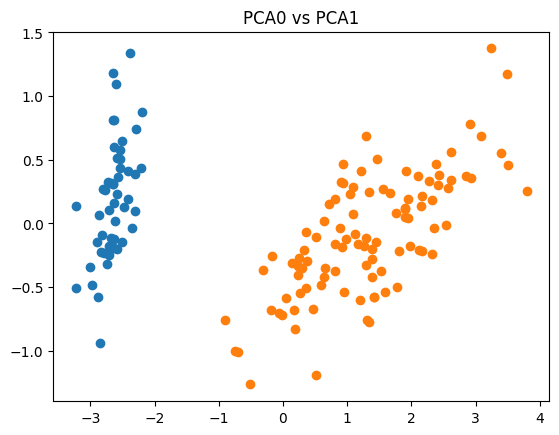

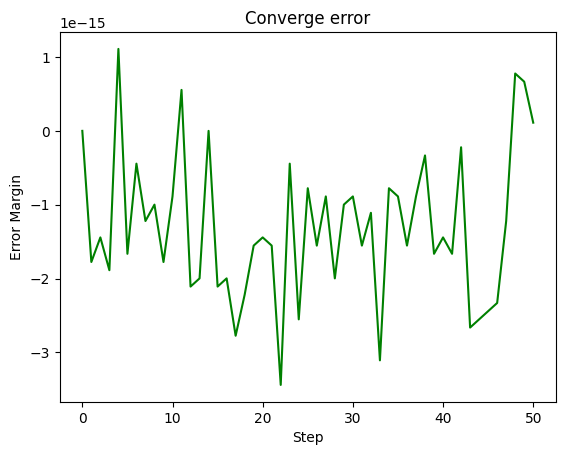

Showing Data for 5 Gaussians and 2 Components


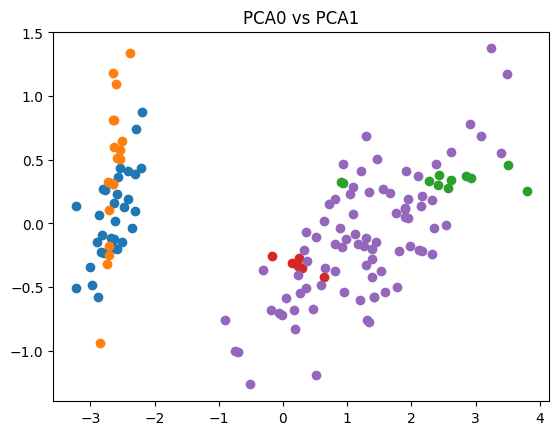

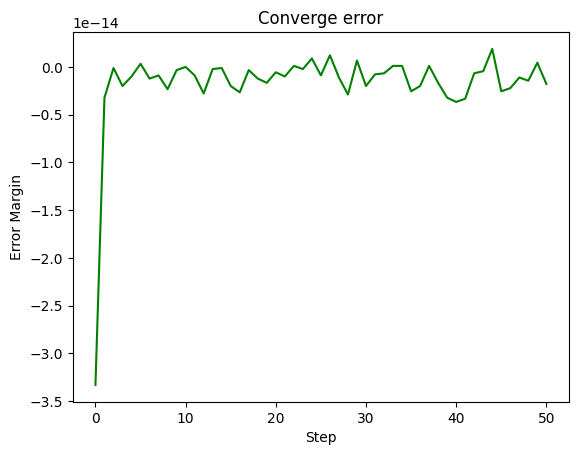

Showing Data for 7 Gaussians and 2 Components


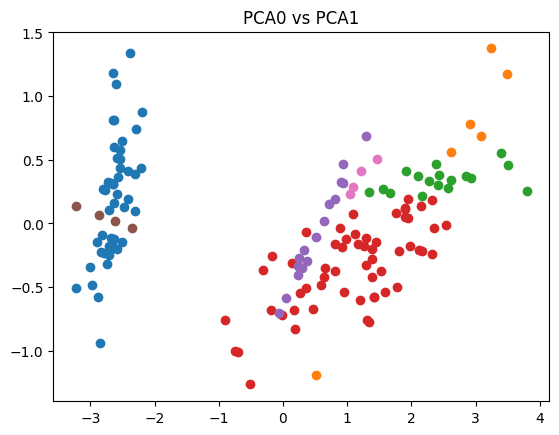

In [147]:
pred_and_graph(data2, [3, 5, 7], [2])

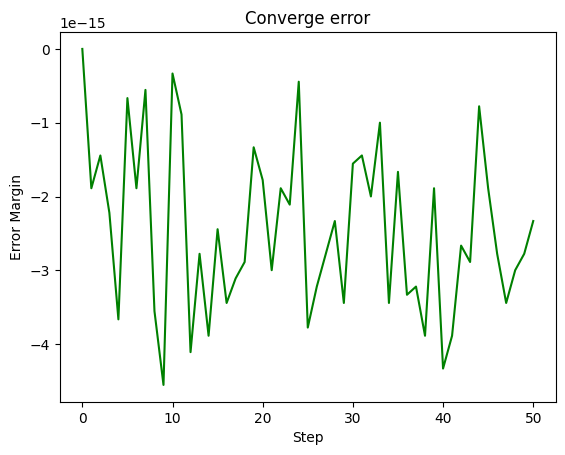

Showing Data for 3 Gaussians and 3 Components


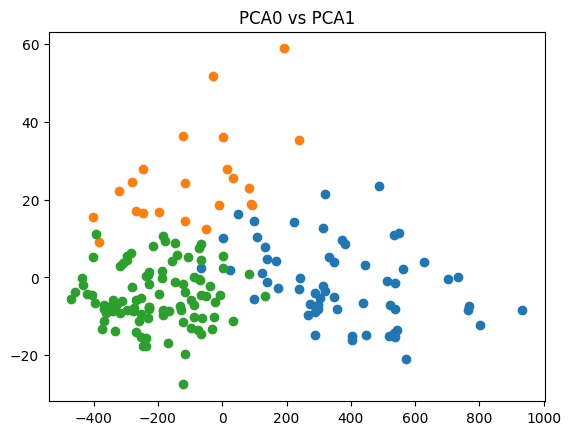

Showing Data for 3 Gaussians and 3 Components


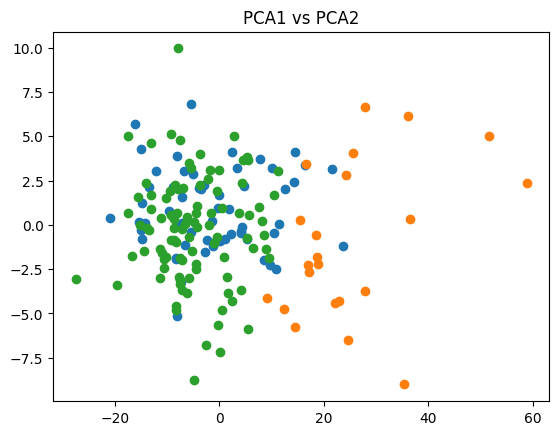

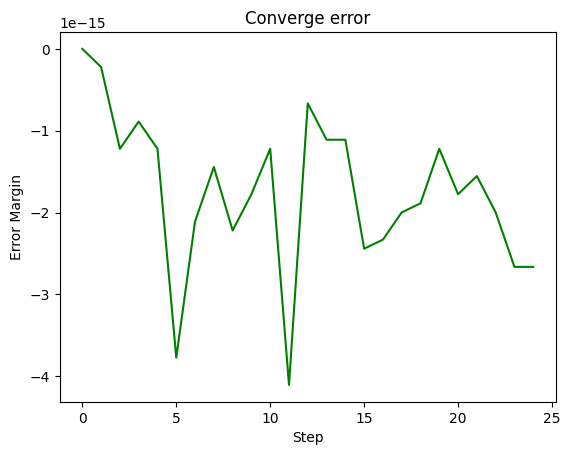

Showing Data for 3 Gaussians and 4 Components


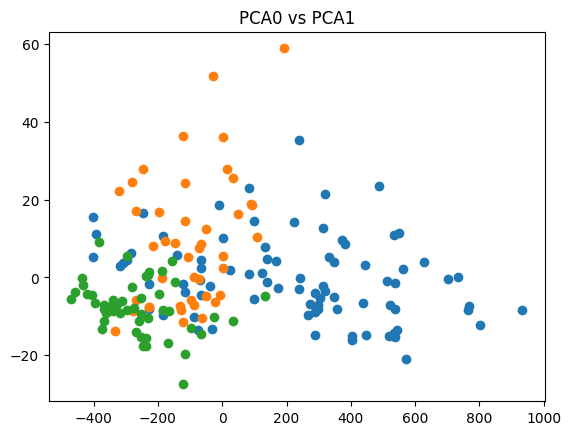

Showing Data for 3 Gaussians and 4 Components


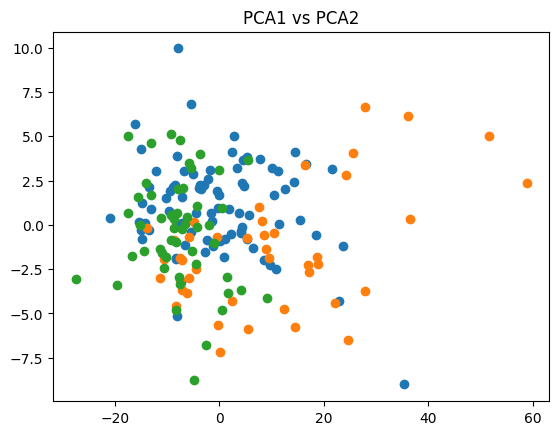

Showing Data for 3 Gaussians and 4 Components


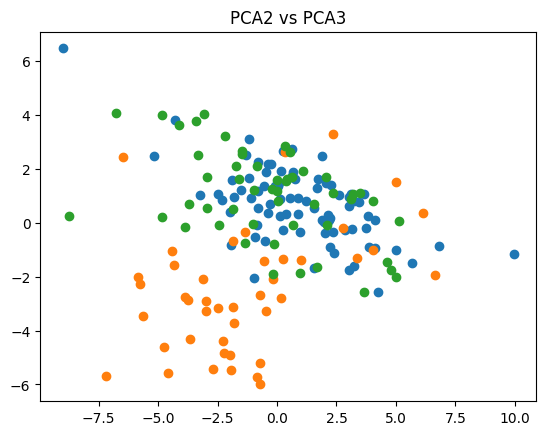

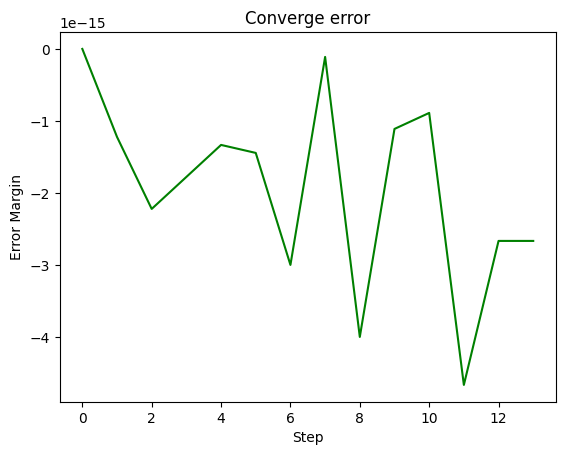

Showing Data for 5 Gaussians and 3 Components


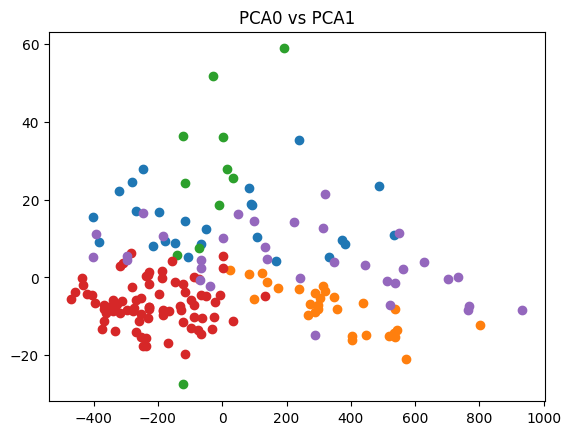

Showing Data for 5 Gaussians and 3 Components


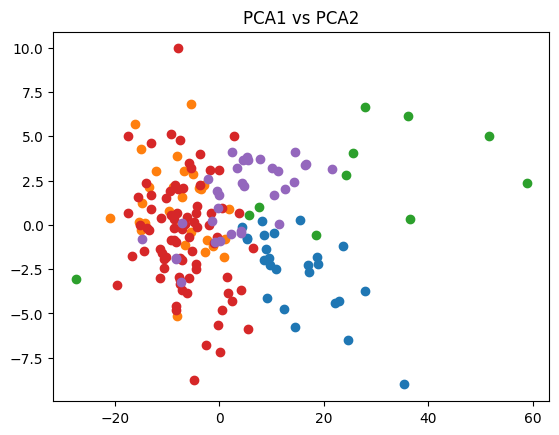

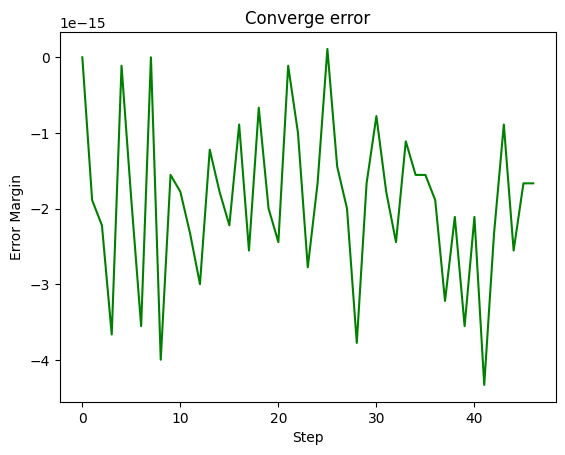

Showing Data for 5 Gaussians and 4 Components


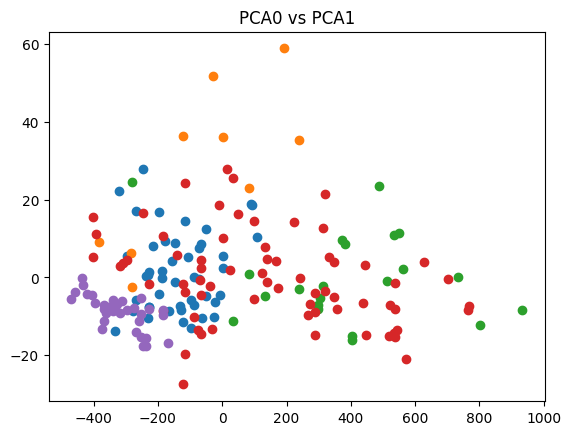

Showing Data for 5 Gaussians and 4 Components


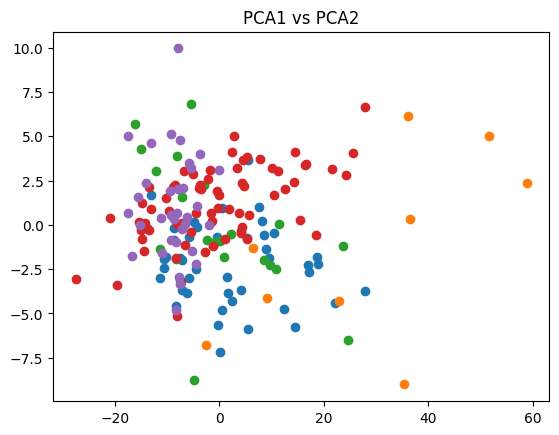

Showing Data for 5 Gaussians and 4 Components


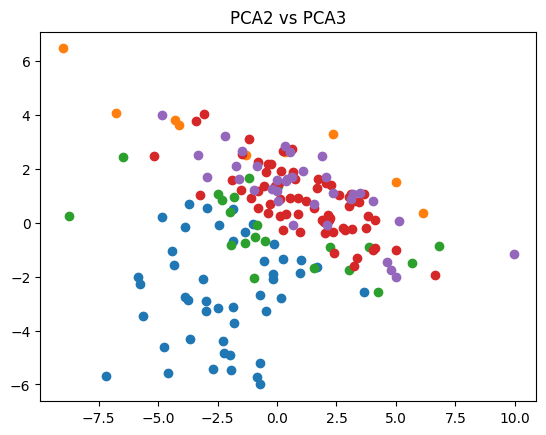

In [146]:
pred_and_graph(data, [3, 5], [3, 4])

# Q9: Comparing Data Sets to sklearn model

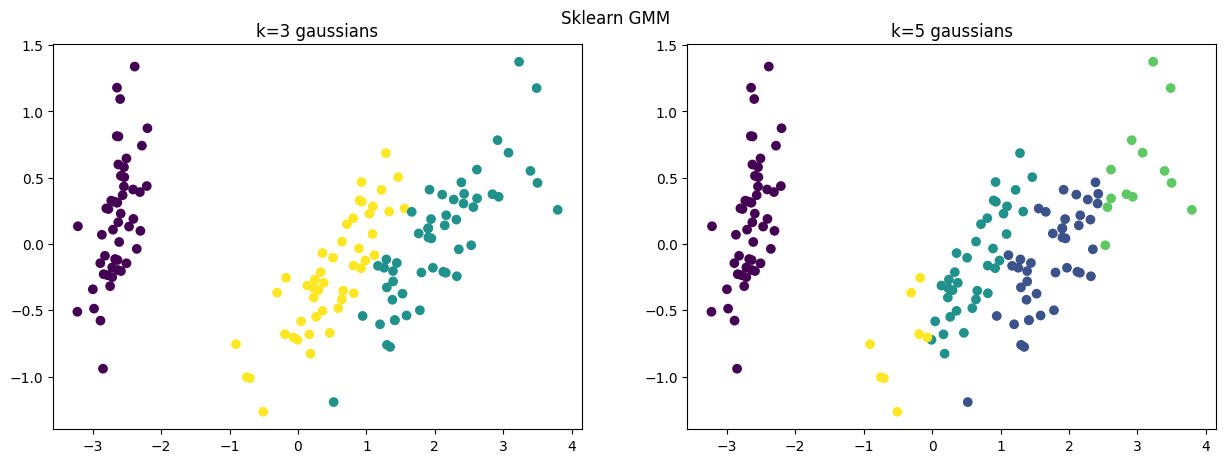

[[ 0.0762983  -0.09766425]]
(1, 2)
this is the prior(as unormalized rk value)for 0: 0.3312733088983001 
this is the covar for 0: [[3.82122443 0.05187014]
 [0.05187014 0.27066159]] 
[[ 0.13152558 -0.10727017]]
(1, 2)
this is the prior(as unormalized rk value)for 1: 0.3357987750306446 
this is the covar for 1: [[3.65982165 0.03058429]
 [0.03058429 0.15177067]] 
[[-0.20857883  0.20537404]]
(1, 2)
this is the prior(as unormalized rk value)for 2: 0.3329279160710553 
this is the covar for 2: [[ 5.05514415 -0.01797868]
 [-0.01797868  0.2383681 ]] 
[[ 0.09878747 -0.10592022]]
(1, 2)
this is the prior(as unormalized rk value)for 0: 0.32931604302015993 
this is the covar for 0: [[3.78202719 0.07797465]
 [0.07797465 0.26061748]] 
[[ 0.18628026 -0.11377506]]
(1, 2)
this is the prior(as unormalized rk value)for 1: 0.33676281693439736 
this is the covar for 1: [[3.59702992 0.05716999]
 [0.05716999 0.15035236]] 
[[-0.2852906   0.21920276]]
(1, 2)
this is the prior(as unormalized rk value)for 2: 0.333

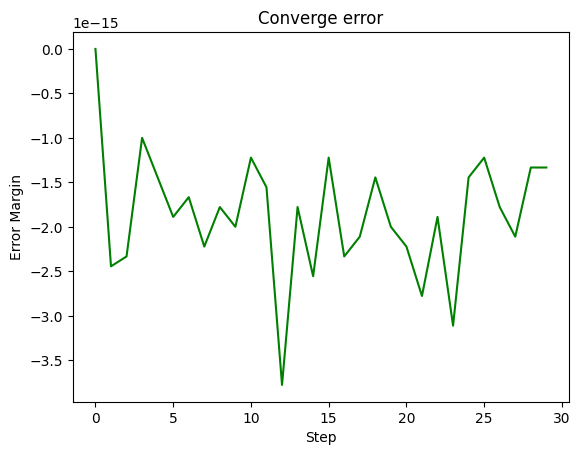

Showing Data for 3 Gaussians and 2 Components


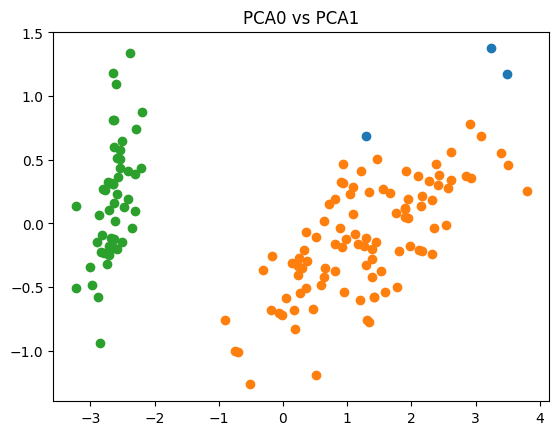

[[ 0.56258103 -0.02822907]]
(1, 2)
this is the prior(as unormalized rk value)for 0: 0.20260001040589784 
this is the covar for 0: [[3.65425996 0.16465333]
 [0.16465333 0.14548855]] 
[[ 0.19119286 -0.00777085]]
(1, 2)
this is the prior(as unormalized rk value)for 1: 0.20005239282819576 
this is the covar for 1: [[4.22962072 0.15946804]
 [0.15946804 0.16699642]] 
[[-0.13057388 -0.0328062 ]]
(1, 2)
this is the prior(as unormalized rk value)for 2: 0.19650679754757333 
this is the covar for 2: [[ 4.07408681e+00 -2.75863759e-03]
 [-2.75863759e-03  3.33004921e-01]] 
[[0.02120687 0.07629804]]
(1, 2)
this is the prior(as unormalized rk value)for 3: 0.19721001221244946 
this is the covar for 3: [[4.57997799 0.05362771]
 [0.05362771 0.29559544]] 
[[-0.64209871 -0.00651331]]
(1, 2)
this is the prior(as unormalized rk value)for 4: 0.20363078700588352 
this is the covar for 4: [[ 3.68766409 -0.3623828 ]
 [-0.3623828   0.25975995]] 
[[ 0.73752782 -0.03394739]]
(1, 2)
this is the prior(as unormalized 

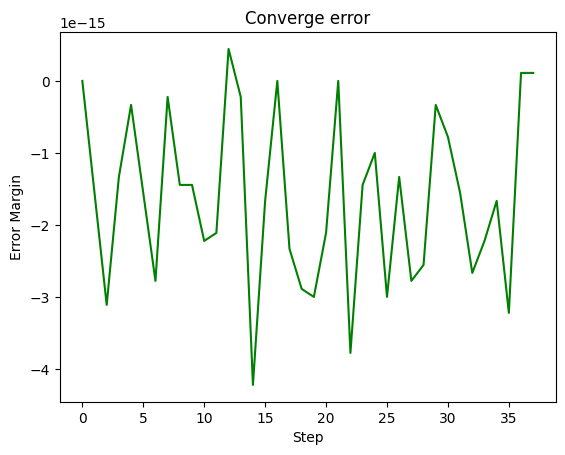

Showing Data for 5 Gaussians and 2 Components


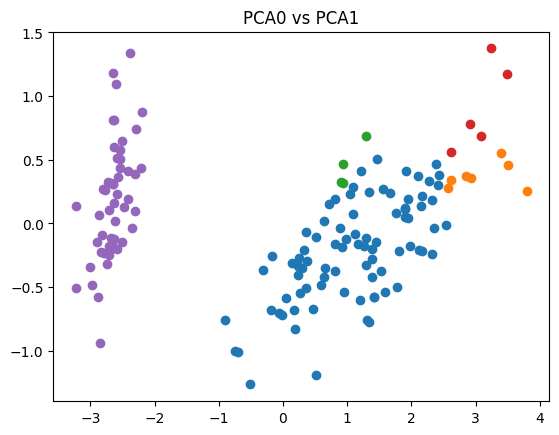

[[<__main__.GMM at 0x7f9db80986a0>, 2], [<__main__.GMM at 0x7f9db8098970>, 2]]

In [64]:

from sklearn.mixture import GaussianMixture
pca = PCA(2)
pca.fit(data2)
data_iris = pca.transform(data2)
predictions = GaussianMixture(n_components=3).fit_predict(data_iris)
predictions1 = GaussianMixture(n_components=5).fit_predict(data_iris)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5 ))

ax1.scatter(data_iris[:, 0], data_iris[:, 1], c=predictions)
ax1.set_title("k=3 gaussians")

ax2.scatter(data_iris[:, 0], data_iris[:, 1], c=predictions1)
ax2.set_title("k=5 gaussians")
plt.suptitle("Sklearn GMM").set_y(0.95)
plt.show()


pred_and_graph(data2, [3,5], [2])

# Q10

### Q7 Response:

The wine data ismost likely paritioned into 3 distinct classes based on observation, so increasing the number of clusters made the data look less distringuishable-- this lead to overfitting when k was set to too high of a value. The data spread becomes pretty hard to visualize beyond 3 dimensions as well to find the right deciision bondaries, so the higher pca dimensions looks as if they have less fit than a PCA of 2. The blue dataset for component=2 seems to be more intermixed between the other 2 classes, indictating it could be useful as a third component, but would be difficult to determine whether or not this 3rd component led the data to capture more variability in data and thus leading to better perfornamce or caused the model to overfit. 

### Q8 Response:

I tested the model on the Iris dataset; incressing the number of clusters for the class made it more mixed and less distinguisable-- the iris dataset also has 3 distinguishable classes and follows a similar pattern to the wine dataset. Having a higher k value means we ask the model to look for decision bounndaires that don't exist and again overfit to non vital patterns. Changing k caused less of a class imbalance, but not as much as the wine dataset.

### Q9 Response:

I think my visualizaiton looks a bit different than the sci-kit learn implementation. There is a much larger proportion of blue and green samples in my classificaition for k=3, c=2, and the sci-kit model for k=5, c=2 have 4 clusters on the right split of the iris data, where as mine has 3 clusters on the right side of the iris data. i think the sci-kit model has a bit more overlap between the middle right clusters, and is a bit more balanced in its class spread than mine. i was not sure if I had any errors when calcuating my repsonsibility matrix or dividng by certain values. Increasing k values also made the discpreancies much more noticable. The difference is probably due mostly to the initialzation strategies which would affect the mean and covariance. if the GMM model used somehting liek k-means to start, it would lead to dfferent partitionings and different convergence criteria where one modle may learn for a longer period than the other. for my convergence, i attempted to find the MLE (log estimate) and made a graph with a max iteraiton of 50 steps.
